
#### Основы нейронных сетей


#### Многослойная сеть на PyTorch

В этом ноутбке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать многослойную полносвязную сеть (Fully-Connected, FC), и сравним их качество на датасете картинок MNIST.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Многослойная нейронная сеть</b></h3>

Как можно понять из названия, многослойная нейросеть состоит из нескольких **слоёв**. Каждый слой состоит из **нейронов**. Ранее мы уже писали свой нейрон на NumPy, вот из таких нейронов и состоит ***MLP (Multi-Layer Perceptron)***. Ещё такую многослойную нейросеть, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне, называют ***Fully-Connected-сетью*** (или ***Dense-сетью***).  

Расмотрим их устройство более подробно:

* Вот так выглядит двухслойная нейросеть (первый слой - input layer - не считается, потому что это, по сути, не слой):

<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg" width=300, height=200>

* Так выглядит трёхслойная нейросеть:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

.. и так далее для большего случая слоёв.

**Обратите внимание:** связи есть у нейронов со слоя $L_{i-1}$  и нейронов $L_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** -- это данные (матрица $(n, m)$).

Слои, которые не являются входными или выходными, называются **скрытыми слоями (hidden layers)**.

При решении ***задачи регрессии*** на **выходном слое** обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на **выходном слое** обычно один нейрон, если задача бинарной классификации, и $K$ нейронов, если задача $K$-класовой классификации.

#### Forward pass в MLP

Каждый слой многослойной нейросети - это матрица весов, строки которой - это нейроны (одна строка - один нейрон), а столбцы - веса каждого нейрона (то есть одна строка - это веса одного нейрона).

Допустим, мы решаем задачу $K$-классовой классификации (на последнем слое $K$ нейронов). Рассмотрим, как в таком случае выглядит `forward_pass` нейросети:

* Вход: $$X =
\left(
\begin{matrix} 
x_{11} & ... & x_{1M} \\
... & \ddots  & ...\\
x_{N1} & ... & x_{NM} 
\end{matrix}
\right)
$$

-- матрица $(N, M)$

* Структура сети - много слоёв, в слоях много нейронов. Первый слой (после входного) выглядит так:

$$ W^1 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_1} \\
... & \ddots  & ...\\
w_{M1} & ... & w_{ML_1} 
\end{matrix}
\right)
$$

-- матрица $(M, L_1)$

То есть это в точности $L_1$ нейронов, каждый имеет свои собственные веса, их $M$ штук.

Мы помним, что нейрон - это линейное преобразование и потом нелинейная функция активации от этого преобразования. Однако в многослойных нейростеях часто отделяют `Linear` часть и `Activation`, то есть слоем считаем набор весов нейронов, а следующий слой всегда функция активации (у всех нейронов из слоя она одна и та же, обычно фреймворки не позволяют задавать конкретному нейрону в слое отличную от других нейронов в этом слое функцию активации, однако это легко сделать, объявив слой из одного нейрона).

* Другие слои выглядит точно так же, как первый слой. Например, у второй слой будет такой:

$$ W^2 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_2} \\
... & \ddots  & ...\\
w_{L_11} & ... & w_{L_1L_2} 
\end{matrix}
\right)
$$

-- матрица $(L_1, L_2)$

То есть это в точности $L_2$ нейронов, каждый имеет свои собственные веса, их $L_1$ штук.

* Выходной слой:  

Пусть в нейросети до выходного слоя идут $t$ слоёв. Тогда выходной слой имеет форму:

$$ W^{out} =
\left(
\begin{matrix} 
w_{11} & ... & w_{1K} \\
... & \ddots  & ...\\
w_{L_t1} & ... & w_{L_tK} 
\end{matrix}
\right)
$$

-- матрица $(L_t, K)$, где $L_t$ - количество нейронов в $t$-ом слое, а $K$ -- количество классов.

В итоге ***для `forward_pass` нам нужно просто последовтельно перемножить матрицы друг за другом, применяя после каждого умножения соответсвующую функцию активации***.

*Примечание*: можно думать об умножении на очередную матрицу весов как на переход в **новое признаковое пространство**. Действительно, когда подаём матрицу $X$ и умножаем на матрицу первого слоя, мы получаем матрицу размера $(N, L_1)$, то есть как будто $L_1$ "новых" признаков (построенных как линейная комбинация старых до применения функции активации, и уже как нелинейная комбинация после активации).

**Backward pass в MLP**

Обучается с помощью метода "Error Backpropagation" - ["Обратное распространение ошибки"](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), принцип распространения очень похож на то, как мы обучали один нейрон - это градиентный спуск, но по "всей нейросети" сразу.  

Backpropagation работает корректно благодаря ***chain rule*** (=правилу взятия производной сложной функции):  

Если $f(x) = f(g(x))$, то:  

$$\frac{\partial{f}}{\partial{x}} = \frac{\partial{f}}{\partial{g}} \frac{\partial{g}}{\partial{x}}$$

Более подробно про backpropagation можно прочитать здесь (на английском):  https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch

## Датасет
Мы будем работать с датасетом "Игрушка дьявола". Генерация и отрисовка датасета:

In [2]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

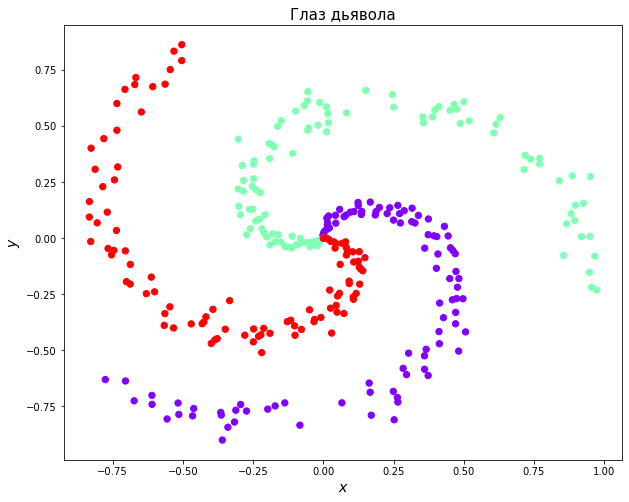

In [3]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Глаз дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

<h3 style="text-align: center;"><b>Многослойная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

## PyTorch для нейронных сетей

Основная абстракция для построения нейронной сети --- это torch.nn.Module. Module --- это те кирпичики, из которых мы будем складывать любую нейронную сеть. Как мы узнали на лекции, для определения модуля достаточно задать методы Forward и Backward. Базовый класс для nn.Module в PyTorch:



In [4]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    :ivar training: Boolean represents whether this module is in training or
                    evaluation mode.
    :vartype training: bool
    


### Модуль Sequential

Основной класс в PyTorch для работы с нейронными сетями --- это  Sequential.  Sequential --- это шаблон для самой простой последовательной нейронной сети. Методы Forward и Backward заданы соответственно: мы пробрасываем выходы и градиенты через все слои, из которых состоит Module. Посмотрим, как это работает.

Не будем медлить - бахнем 100 нейронов в двуслойную нейросеть. 

In [5]:
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 64, 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

Посмотрим, что у нас получилось. Пропустим мусорные данные через нашу модель методом forward.

In [6]:
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])

Weight shapes: [torch.Size([100, 2]), torch.Size([100]), torch.Size([3, 100]), torch.Size([3])]


In [7]:
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got

C:\Users\zaket\anaconda3\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.3360, 0.3481, 0.3159], grad_fn=<SelectBackward>)

## Код для генерации мини-батчей



In [8]:
from torch.autograd import Variable

In [9]:
def batch_gen(X, y, batch_size=128):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))

In [10]:
batch_gen(X, y)[1].shape

torch.Size([128])

In [11]:
two_layer_net.forward(batch_gen(X,y)[0])

tensor([[0.3353, 0.3651, 0.2997],
        [0.3432, 0.3416, 0.3152],
        [0.2971, 0.4182, 0.2847],
        [0.3189, 0.3872, 0.2940],
        [0.3414, 0.3224, 0.3363],
        [0.2951, 0.4201, 0.2848],
        [0.3342, 0.3134, 0.3523],
        [0.3338, 0.3516, 0.3145],
        [0.3317, 0.3633, 0.3050],
        [0.3474, 0.3416, 0.3111],
        [0.3439, 0.3454, 0.3107],
        [0.3567, 0.3244, 0.3189],
        [0.3113, 0.3821, 0.3066],
        [0.3180, 0.3818, 0.3002],
        [0.3445, 0.3400, 0.3155],
        [0.3501, 0.3084, 0.3416],
        [0.3159, 0.4097, 0.2744],
        [0.3339, 0.3499, 0.3163],
        [0.3408, 0.3554, 0.3038],
        [0.2882, 0.4233, 0.2885],
        [0.3424, 0.3375, 0.3201],
        [0.3497, 0.3093, 0.3410],
        [0.3497, 0.3093, 0.3410],
        [0.3353, 0.3651, 0.2997],
        [0.3581, 0.3198, 0.3220],
        [0.3324, 0.3610, 0.3066],
        [0.3497, 0.3093, 0.3410],
        [0.3424, 0.3448, 0.3128],
        [0.2949, 0.4208, 0.2843],
        [0.335

Не забываем оборачивать данные (без этого градиенты не посчитать):

## Функция потерь и оптимизатор

In [12]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

C:\Users\zaket\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Обучение модели

In [13]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
for t in range(10000):
    x_batch, y_batch = batch_gen(X, y)
    
    # forward
    y_pred = two_layer_net(x_batch)

    # loss
    loss = loss_fn(y_pred, y_batch)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

0 142.0894012451172
1 141.4705810546875
2 141.869140625
3 141.60227966308594
4 142.0009765625
5 141.27169799804688
6 141.33270263671875
7 141.19247436523438
8 141.2882080078125
9 141.11337280273438
10 141.73098754882812
11 141.58514404296875
12 141.47232055664062
13 140.90101623535156
14 141.0750732421875
15 140.92587280273438
16 141.3580322265625
17 141.14462280273438
18 140.8075408935547
19 141.54446411132812
20 141.06350708007812
21 140.8662567138672
22 140.6751708984375
23 140.8115997314453
24 140.4264373779297
25 140.537841796875
26 140.52337646484375
27 140.81240844726562
28 140.2690887451172
29 141.01834106445312
30 140.69058227539062
31 140.9498291015625
32 140.10528564453125
33 140.455322265625
34 140.67111206054688
35 140.23780822753906
36 140.13900756835938
37 140.09732055664062
38 139.92933654785156
39 140.06874084472656
40 140.35464477539062
41 139.99176025390625
42 140.7793426513672
43 140.1241912841797
44 139.90756225585938
45 140.18869018554688
46 139.4876251220703
47 1

433 129.72439575195312
434 128.52015686035156
435 130.39657592773438
436 127.83606719970703
437 127.92241668701172
438 127.61000061035156
439 128.47218322753906
440 126.35907745361328
441 129.55282592773438
442 126.18267059326172
443 125.1266098022461
444 128.85850524902344
445 127.2179946899414
446 127.9926986694336
447 129.13540649414062
448 126.94637298583984
449 128.2582244873047
450 128.71463012695312
451 127.7212142944336
452 127.94446563720703
453 126.81672668457031
454 128.506591796875
455 126.1079330444336
456 129.3588409423828
457 129.60443115234375
458 127.79495239257812
459 127.78803253173828
460 128.4296417236328
461 127.07634735107422
462 128.75856018066406
463 127.90823364257812
464 126.99739074707031
465 128.80426025390625
466 127.80647277832031
467 127.68927001953125
468 129.078369140625
469 127.58187866210938
470 128.48472595214844
471 125.39592742919922
472 126.59585571289062
473 124.91771697998047
474 128.6065673828125
475 127.80460357666016
476 127.54071044921875
4

915 120.01480865478516
916 122.73684692382812
917 123.00732421875
918 121.93769073486328
919 127.07610321044922
920 122.78180694580078
921 123.31013488769531
922 126.13461303710938
923 125.0602035522461
924 122.76747131347656
925 121.62137603759766
926 120.3251724243164
927 122.43793487548828
928 119.10702514648438
929 121.74213409423828
930 121.10314178466797
931 120.81632995605469
932 123.40193176269531
933 120.66010284423828
934 121.46047973632812
935 119.57181549072266
936 120.95455169677734
937 123.17845916748047
938 122.73053741455078
939 121.64291381835938
940 121.7483139038086
941 124.79541015625
942 121.39201354980469
943 124.32750701904297
944 120.02447509765625
945 119.20159912109375
946 119.63501739501953
947 120.21969604492188
948 126.04816436767578
949 123.79627227783203
950 121.6698989868164
951 120.78655242919922
952 122.99508666992188
953 121.57193756103516
954 122.38394165039062
955 118.74300384521484
956 121.25566864013672
957 124.88922119140625
958 120.0257492065429

1390 117.50069427490234
1391 121.22752380371094
1392 120.9787368774414
1393 116.82249450683594
1394 121.25739288330078
1395 118.15274047851562
1396 114.73836517333984
1397 116.3859634399414
1398 119.7253646850586
1399 115.2558364868164
1400 119.83731079101562
1401 116.93315887451172
1402 119.61454010009766
1403 122.4349594116211
1404 117.72651672363281
1405 118.46180725097656
1406 120.38697814941406
1407 115.47118377685547
1408 121.56888580322266
1409 120.2239990234375
1410 118.5523452758789
1411 118.03956604003906
1412 117.12825012207031
1413 117.65706634521484
1414 114.791748046875
1415 120.43632507324219
1416 120.03060150146484
1417 118.00581359863281
1418 117.77177429199219
1419 116.60730743408203
1420 120.73638916015625
1421 119.84960174560547
1422 120.32041931152344
1423 119.47882843017578
1424 119.01313781738281
1425 121.6844253540039
1426 121.27128601074219
1427 124.53357696533203
1428 119.49028778076172
1429 120.90249633789062
1430 122.99703216552734
1431 118.91276550292969
14

1874 116.93209075927734
1875 119.80320739746094
1876 114.61685180664062
1877 120.4937973022461
1878 117.60002899169922
1879 117.20616149902344
1880 116.23751068115234
1881 117.53411102294922
1882 115.59294891357422
1883 120.25130462646484
1884 117.71205139160156
1885 120.81876373291016
1886 120.09883117675781
1887 118.8373031616211
1888 116.90872955322266
1889 121.30438995361328
1890 116.55057525634766
1891 121.60498809814453
1892 117.97947692871094
1893 121.87088775634766
1894 117.21654510498047
1895 120.33463287353516
1896 115.55773162841797
1897 121.12566375732422
1898 119.6666488647461
1899 122.37899780273438
1900 114.75664520263672
1901 115.35957336425781
1902 122.79177856445312
1903 113.0083999633789
1904 113.79373931884766
1905 116.80652618408203
1906 118.2596206665039
1907 112.48346710205078
1908 117.56502532958984
1909 120.21735382080078
1910 118.99198913574219
1911 116.38511657714844
1912 115.3288345336914
1913 117.0530014038086
1914 117.17416381835938
1915 120.83446502685547

2360 118.11148834228516
2361 117.3415756225586
2362 117.34986114501953
2363 114.08592224121094
2364 117.46922302246094
2365 117.90042877197266
2366 118.80535888671875
2367 122.06771087646484
2368 112.12942504882812
2369 120.10736083984375
2370 120.14111328125
2371 115.7085189819336
2372 116.80888366699219
2373 115.83074188232422
2374 115.85081481933594
2375 114.84418487548828
2376 118.33109283447266
2377 119.32186126708984
2378 119.21932220458984
2379 124.70848846435547
2380 119.40179443359375
2381 115.96000671386719
2382 118.366455078125
2383 118.76923370361328
2384 114.56893920898438
2385 122.7620620727539
2386 118.39352416992188
2387 118.76697540283203
2388 118.17771911621094
2389 116.23717498779297
2390 114.90746307373047
2391 114.49171447753906
2392 113.37337493896484
2393 115.71550750732422
2394 110.78770446777344
2395 117.48700714111328
2396 118.58822631835938
2397 116.34854888916016
2398 114.65753936767578
2399 118.3551025390625
2400 114.94078063964844
2401 116.69927215576172
2

2837 114.15531158447266
2838 122.27914428710938
2839 115.56829833984375
2840 112.1556625366211
2841 119.27777862548828
2842 120.10355377197266
2843 115.73645782470703
2844 115.19683074951172
2845 115.97003936767578
2846 120.3122787475586
2847 117.16070556640625
2848 120.34107208251953
2849 118.0694808959961
2850 120.95600891113281
2851 114.66458129882812
2852 115.42743682861328
2853 116.0394515991211
2854 111.13138580322266
2855 122.41645050048828
2856 115.6363754272461
2857 118.04708099365234
2858 114.01966094970703
2859 116.0268325805664
2860 116.50261688232422
2861 116.88652801513672
2862 114.39441680908203
2863 114.34256744384766
2864 113.9820785522461
2865 113.72123718261719
2866 116.22066497802734
2867 111.71758270263672
2868 115.75548553466797
2869 119.97777557373047
2870 118.2577896118164
2871 120.01570129394531
2872 116.71409606933594
2873 118.8705062866211
2874 118.30789184570312
2875 118.0902099609375
2876 117.27670288085938
2877 122.50129699707031
2878 112.8535385131836
287

3306 118.43628692626953
3307 112.87879180908203
3308 115.46450805664062
3309 115.2732925415039
3310 113.86817169189453
3311 113.02301025390625
3312 115.90392303466797
3313 117.05840301513672
3314 115.87911224365234
3315 117.44898986816406
3316 115.67416381835938
3317 117.60655212402344
3318 117.06172180175781
3319 116.45140075683594
3320 116.55303192138672
3321 115.22525024414062
3322 112.29310607910156
3323 117.40973663330078
3324 115.10693359375
3325 114.97048950195312
3326 117.59317016601562
3327 116.8716812133789
3328 114.89875793457031
3329 112.78389739990234
3330 117.8127670288086
3331 118.93994903564453
3332 114.69054412841797
3333 116.53748321533203
3334 116.60719299316406
3335 115.5223159790039
3336 120.00684356689453
3337 114.41346740722656
3338 113.70101928710938
3339 117.1932373046875
3340 113.9800796508789
3341 117.84573364257812
3342 117.89290618896484
3343 114.97811126708984
3344 113.40499877929688
3345 117.36721801757812
3346 116.39209747314453
3347 115.1163330078125
33

3794 113.07466888427734
3795 120.09019470214844
3796 111.07229614257812
3797 115.88066101074219
3798 115.77803802490234
3799 113.00820922851562
3800 117.04637145996094
3801 117.10529327392578
3802 120.300537109375
3803 111.19965362548828
3804 116.83678436279297
3805 116.55325317382812
3806 112.44696044921875
3807 113.50794219970703
3808 115.98030853271484
3809 115.91374206542969
3810 116.17493438720703
3811 116.88702392578125
3812 117.94390869140625
3813 119.00852966308594
3814 113.36378479003906
3815 114.05660247802734
3816 110.40984344482422
3817 112.57722473144531
3818 115.73574829101562
3819 111.42332458496094
3820 111.31063079833984
3821 117.05866241455078
3822 114.2444839477539
3823 119.92384338378906
3824 119.56710815429688
3825 113.94403839111328
3826 113.68084716796875
3827 114.31318664550781
3828 112.46817779541016
3829 117.30191040039062
3830 115.32036590576172
3831 114.921875
3832 113.02081298828125
3833 115.7322769165039
3834 116.8377914428711
3835 116.64369201660156
3836 

4279 112.27387237548828
4280 112.75911712646484
4281 111.98998260498047
4282 113.13938903808594
4283 114.02598571777344
4284 117.48333740234375
4285 114.02368927001953
4286 113.34185028076172
4287 117.51944732666016
4288 116.12550354003906
4289 116.53596496582031
4290 118.31436920166016
4291 116.93212127685547
4292 116.13916778564453
4293 114.10246276855469
4294 115.69780731201172
4295 118.14080047607422
4296 116.33634185791016
4297 114.13643646240234
4298 112.82432556152344
4299 116.8256607055664
4300 115.03620147705078
4301 115.86722564697266
4302 111.76590728759766
4303 113.07979583740234
4304 109.96727752685547
4305 118.21357727050781
4306 118.43212890625
4307 116.1478042602539
4308 114.2350082397461
4309 118.02225494384766
4310 112.6466064453125
4311 114.18830871582031
4312 112.54829406738281
4313 118.31951904296875
4314 121.241455078125
4315 118.81407165527344
4316 112.70144653320312
4317 117.25263214111328
4318 109.36750030517578
4319 114.49390411376953
4320 107.44922637939453
4

4749 116.4976806640625
4750 112.51095581054688
4751 111.3468246459961
4752 115.84911346435547
4753 115.63565826416016
4754 115.294677734375
4755 112.99752807617188
4756 111.62030029296875
4757 114.91446685791016
4758 111.37348937988281
4759 110.49006652832031
4760 114.09324645996094
4761 117.23169708251953
4762 110.90479278564453
4763 110.08264923095703
4764 114.91648864746094
4765 112.30271911621094
4766 109.52334594726562
4767 106.49737548828125
4768 114.10991668701172
4769 119.77471160888672
4770 116.59772491455078
4771 111.113037109375
4772 114.55489349365234
4773 114.61931610107422
4774 117.86316680908203
4775 114.27194213867188
4776 115.02670288085938
4777 112.28568267822266
4778 111.92884063720703
4779 114.23766326904297
4780 118.85916137695312
4781 114.79070281982422
4782 110.79315948486328
4783 108.51627349853516
4784 112.19280242919922
4785 113.92664337158203
4786 110.82331085205078
4787 109.22079467773438
4788 113.36448669433594
4789 113.8380355834961
4790 116.26075744628906

5206 108.65072631835938
5207 111.57225036621094
5208 110.7157974243164
5209 113.27783203125
5210 114.45738220214844
5211 113.22286224365234
5212 113.9233169555664
5213 110.80810546875
5214 115.03569793701172
5215 114.87449645996094
5216 115.68854522705078
5217 117.80945587158203
5218 111.31007385253906
5219 114.75850677490234
5220 113.36211395263672
5221 109.8057861328125
5222 110.80123901367188
5223 113.6832275390625
5224 109.731201171875
5225 117.99315643310547
5226 119.56806182861328
5227 115.58655548095703
5228 112.93313598632812
5229 112.79154968261719
5230 108.56340789794922
5231 110.8800277709961
5232 114.1537094116211
5233 110.87464141845703
5234 115.89692687988281
5235 109.87666320800781
5236 116.1036376953125
5237 111.91815185546875
5238 113.83853149414062
5239 114.48808288574219
5240 115.51245880126953
5241 111.30133056640625
5242 114.34842681884766
5243 111.04142761230469
5244 111.78079986572266
5245 116.40969848632812
5246 111.25638580322266
5247 120.50900268554688
5248 11

5684 113.66521453857422
5685 111.94253540039062
5686 109.8367691040039
5687 117.04891967773438
5688 110.87397766113281
5689 111.2046127319336
5690 113.60894775390625
5691 112.21573638916016
5692 113.19473266601562
5693 106.46589660644531
5694 116.00870513916016
5695 106.60981750488281
5696 108.41691589355469
5697 106.31044006347656
5698 112.78358459472656
5699 115.95692443847656
5700 111.84364318847656
5701 108.88347625732422
5702 119.33842468261719
5703 113.41854858398438
5704 117.30256652832031
5705 113.51797485351562
5706 107.7519302368164
5707 114.17562866210938
5708 106.60356140136719
5709 116.59246826171875
5710 111.80593872070312
5711 112.76717376708984
5712 112.1524429321289
5713 112.28099060058594
5714 116.98543548583984
5715 110.20719909667969
5716 115.5855941772461
5717 109.5074234008789
5718 107.92264556884766
5719 113.24725341796875
5720 112.57617950439453
5721 113.08363342285156
5722 113.22835540771484
5723 114.7507095336914
5724 115.10494232177734
5725 113.17308807373047

6147 114.42845916748047
6148 118.68663787841797
6149 110.15512084960938
6150 108.92313385009766
6151 113.49910736083984
6152 117.4371109008789
6153 106.54574584960938
6154 112.36589050292969
6155 110.14884185791016
6156 113.61335754394531
6157 112.2144775390625
6158 112.05420684814453
6159 113.55420684814453
6160 111.30852508544922
6161 113.17689514160156
6162 114.93505096435547
6163 106.33940124511719
6164 112.51424407958984
6165 110.67071533203125
6166 108.23625946044922
6167 111.02000427246094
6168 106.44619750976562
6169 109.90997314453125
6170 111.81424713134766
6171 111.22200775146484
6172 114.34544372558594
6173 110.36090087890625
6174 110.53028106689453
6175 121.61231994628906
6176 110.1580810546875
6177 112.90737915039062
6178 109.90755462646484
6179 116.5029296875
6180 111.98750305175781
6181 112.0228500366211
6182 110.45970916748047
6183 110.72037506103516
6184 112.63478088378906
6185 114.1609878540039
6186 111.35372924804688
6187 110.71448516845703
6188 113.22866821289062
6

6630 105.31244659423828
6631 109.54193878173828
6632 109.08910369873047
6633 111.03556823730469
6634 114.60713958740234
6635 110.83457946777344
6636 112.49462890625
6637 108.24191284179688
6638 114.19454956054688
6639 108.16057586669922
6640 109.78302001953125
6641 114.12326049804688
6642 111.90489196777344
6643 108.64163970947266
6644 110.28278350830078
6645 108.40306091308594
6646 111.5887680053711
6647 111.55327606201172
6648 117.94564056396484
6649 110.94100189208984
6650 111.95325469970703
6651 110.79469299316406
6652 113.5071029663086
6653 112.16799926757812
6654 112.972900390625
6655 111.0376205444336
6656 113.7380599975586
6657 111.60942840576172
6658 110.11339569091797
6659 110.05752563476562
6660 112.40416717529297
6661 108.50602722167969
6662 109.63884735107422
6663 112.17471313476562
6664 108.92556762695312
6665 113.49304962158203
6666 105.52162170410156
6667 111.51908874511719
6668 111.34642791748047
6669 109.07345581054688
6670 115.0235595703125
6671 115.5926742553711
667

7088 110.38990020751953
7089 109.95387268066406
7090 115.22657775878906
7091 108.23970794677734
7092 116.66498565673828
7093 112.48605346679688
7094 107.75652313232422
7095 110.76299285888672
7096 116.78117370605469
7097 110.9375228881836
7098 112.97598266601562
7099 109.68046569824219
7100 112.78520965576172
7101 109.5575180053711
7102 111.50252532958984
7103 110.3644790649414
7104 115.86161041259766
7105 111.34538269042969
7106 108.21128845214844
7107 109.4906005859375
7108 110.3136215209961
7109 111.82315826416016
7110 114.04360961914062
7111 118.15697479248047
7112 114.92814636230469
7113 111.67985534667969
7114 110.26045989990234
7115 106.15165710449219
7116 111.0526123046875
7117 112.12828826904297
7118 107.03235626220703
7119 109.7919921875
7120 113.24163818359375
7121 112.19743347167969
7122 111.33294677734375
7123 105.86463928222656
7124 107.69010162353516
7125 105.98809814453125
7126 110.77476501464844
7127 110.9450454711914
7128 114.3238754272461
7129 111.64813232421875
7130

7567 112.81707000732422
7568 110.5860595703125
7569 113.35137176513672
7570 110.34321594238281
7571 112.87092590332031
7572 114.29774475097656
7573 109.0179443359375
7574 109.85960388183594
7575 110.0268783569336
7576 113.28856658935547
7577 113.78658294677734
7578 108.77310180664062
7579 106.48661041259766
7580 111.21884155273438
7581 109.49256896972656
7582 113.092041015625
7583 109.49442291259766
7584 107.68379974365234
7585 113.36662292480469
7586 111.41438293457031
7587 108.85540771484375
7588 104.7625961303711
7589 108.70707702636719
7590 108.56997680664062
7591 112.11139678955078
7592 108.614990234375
7593 111.29948425292969
7594 116.4737319946289
7595 117.54305267333984
7596 109.27042388916016
7597 111.03387451171875
7598 111.67327880859375
7599 108.15502166748047
7600 107.63335418701172
7601 110.05916595458984
7602 109.85658264160156
7603 105.3885498046875
7604 104.9108657836914
7605 107.8834457397461
7606 105.66868591308594
7607 108.18209838867188
7608 108.7691650390625
7609 

8042 112.02861022949219
8043 109.34825134277344
8044 107.16255950927734
8045 103.33486938476562
8046 106.48808288574219
8047 106.58000183105469
8048 107.03545379638672
8049 112.92229461669922
8050 106.7147445678711
8051 110.29657745361328
8052 110.90567779541016
8053 104.25386047363281
8054 109.23487854003906
8055 115.40699768066406
8056 105.49385833740234
8057 110.8266372680664
8058 109.75252532958984
8059 107.61148071289062
8060 110.52448272705078
8061 112.69859313964844
8062 109.91522979736328
8063 109.5500259399414
8064 108.12345886230469
8065 106.36479187011719
8066 108.89462280273438
8067 106.81816101074219
8068 110.235595703125
8069 111.79132843017578
8070 107.32904052734375
8071 106.5703353881836
8072 105.82501220703125
8073 112.32518768310547
8074 105.84341430664062
8075 107.93537902832031
8076 109.7209243774414
8077 108.00286865234375
8078 108.41309356689453
8079 109.31282043457031
8080 109.22230529785156
8081 103.87310791015625
8082 110.51365661621094
8083 108.68000030517578

8526 112.0592269897461
8527 104.85326385498047
8528 108.26215362548828
8529 108.01019287109375
8530 110.61616516113281
8531 108.11405181884766
8532 107.91581726074219
8533 110.95417022705078
8534 109.87897491455078
8535 108.03035736083984
8536 113.01261901855469
8537 113.7994384765625
8538 107.9967269897461
8539 106.16768646240234
8540 109.30831909179688
8541 116.47652435302734
8542 110.48677825927734
8543 108.54933166503906
8544 109.51612091064453
8545 102.94367980957031
8546 108.42872619628906
8547 105.36512756347656
8548 111.82988739013672
8549 109.7137680053711
8550 111.93324279785156
8551 111.32736206054688
8552 108.90512084960938
8553 109.17035675048828
8554 107.4835433959961
8555 106.15554809570312
8556 108.13397979736328
8557 109.871337890625
8558 107.19214630126953
8559 109.61166381835938
8560 110.30591583251953
8561 101.48558807373047
8562 112.75569915771484
8563 107.44096374511719
8564 107.18807220458984
8565 107.85769653320312
8566 108.28939056396484
8567 109.27201843261719

9004 108.64677429199219
9005 105.01271057128906
9006 109.87816619873047
9007 109.76197052001953
9008 108.92833709716797
9009 101.67689514160156
9010 107.79354858398438
9011 107.6708984375
9012 105.93462371826172
9013 107.250732421875
9014 109.04814910888672
9015 109.1905746459961
9016 106.48045349121094
9017 109.67546081542969
9018 107.0447998046875
9019 108.42520904541016
9020 110.53548431396484
9021 104.04783630371094
9022 108.03793334960938
9023 109.76274871826172
9024 107.9317398071289
9025 102.92716217041016
9026 108.07482147216797
9027 110.14617156982422
9028 105.48503112792969
9029 106.62732696533203
9030 113.41059112548828
9031 109.71238708496094
9032 105.66696166992188
9033 104.05097961425781
9034 110.99567413330078
9035 105.9547348022461
9036 109.48892211914062
9037 101.26331329345703
9038 101.32620239257812
9039 106.98324584960938
9040 104.80655670166016
9041 105.09028625488281
9042 110.59210968017578
9043 110.21988677978516
9044 109.54081726074219
9045 106.24808502197266
90

9479 105.43447875976562
9480 105.47481536865234
9481 104.39977264404297
9482 103.7227783203125
9483 111.33968353271484
9484 104.74824523925781
9485 104.94485473632812
9486 108.41783905029297
9487 111.82476806640625
9488 108.70813751220703
9489 105.80146789550781
9490 108.78900146484375
9491 105.25572204589844
9492 105.92375946044922
9493 103.6678237915039
9494 109.75390625
9495 105.76216888427734
9496 108.274169921875
9497 102.78565979003906
9498 107.8416519165039
9499 105.75381469726562
9500 107.75222778320312
9501 111.64615631103516
9502 104.91026306152344
9503 106.72805786132812
9504 107.8349380493164
9505 108.13461303710938
9506 104.78138732910156
9507 105.46075439453125
9508 106.44884490966797
9509 107.99972534179688
9510 103.60488891601562
9511 108.9507064819336
9512 104.62274169921875
9513 103.40245819091797
9514 106.77643585205078
9515 113.52233123779297
9516 108.70523071289062
9517 103.1512451171875
9518 106.46007537841797
9519 106.79798889160156
9520 108.77462005615234
9521 1

9957 109.4065933227539
9958 102.34911346435547
9959 100.0752944946289
9960 106.73640441894531
9961 107.53852081298828
9962 107.88671112060547
9963 110.06005859375
9964 105.75758361816406
9965 108.0868911743164
9966 106.59590148925781
9967 105.82030487060547
9968 107.61192321777344
9969 107.45108032226562
9970 109.22735595703125
9971 103.67176055908203
9972 108.63018035888672
9973 104.65206146240234
9974 102.24637603759766
9975 106.34992980957031
9976 105.01507568359375
9977 103.95405578613281
9978 104.63134002685547
9979 105.54698181152344
9980 106.73426818847656
9981 103.1982650756836
9982 107.00797271728516
9983 105.55776977539062
9984 104.81269836425781
9985 103.05175018310547
9986 104.86981201171875
9987 103.26023864746094
9988 107.15642547607422
9989 113.19544219970703
9990 105.81893920898438
9991 106.05579376220703
9992 102.25667572021484
9993 107.0962905883789
9994 110.20767974853516
9995 106.6935043334961
9996 111.34423065185547
9997 109.0552978515625
9998 106.7200927734375
999

**Обратите внимание:** несмотря на то, что это задача 3-х классовой классификации и столбец $y$ нужно по-хорошему кодировать OneHotEncoding'ом, мы подали просто столбец из 0, 1 и 2 и всё отработало. Вывод - PyTorch сам делает OneHot в таком случае.

Проверим, насколько хороша наша сеть из 100 нейронов:

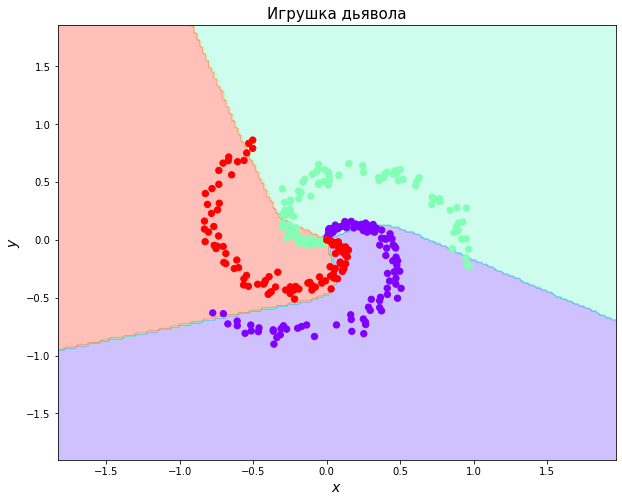

In [14]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Качество не очень. Как же так, ведь мы использовали 100 нейронов? Разве их мало?

---

### Задача 1


Улучшите сеть (помните про вещи, которые можно менять (см. Компоненты нейросети)). Экспериментируйте, в этом **вся суть deep learning** (и в том, чтобы рано или поздно сетка научилась экспериментировать за Вас :)

In [17]:
# Ваш код здесь (можно (и нужно) создавать больше ячеек)

from torch.autograd import Variable
# Ваш код здесь (можно (и нужно) создавать больше ячеек)
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 30, 2, 4000, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got


def batch_gen(X, y, batch_size=128):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
for t in range(10000):
    x_batch, y_batch = batch_gen(X, y)
    
    # forward
    y_pred = two_layer_net(x_batch)

    # loss
    loss = loss_fn(y_pred, y_batch)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()
    

Weight shapes: [torch.Size([4000, 2]), torch.Size([4000]), torch.Size([3, 4000]), torch.Size([3])]
0 140.20156860351562
1 138.67926025390625
2 136.72303771972656
3 135.6591339111328
4 132.91368103027344
5 133.91738891601562
6 133.31698608398438
7 130.2244110107422
8 131.6708984375
9 128.55099487304688
10 130.42478942871094
11 129.2305908203125
12 126.82909393310547
13 125.1224136352539
14 129.9672088623047
15 125.54369354248047
16 123.43353271484375
17 125.91360473632812
18 124.07879638671875
19 120.08753967285156
20 121.34073638916016
21 124.24185180664062
22 118.30905151367188
23 119.21842193603516
24 122.68630981445312
25 126.51593780517578
26 121.90580749511719
27 119.79949188232422
28 121.73091888427734
29 121.23370361328125
30 118.05642700195312
31 119.52918243408203
32 118.88765716552734
33 122.22826385498047
34 122.4853744506836
35 121.02632141113281
36 123.02122497558594
37 116.96292114257812
38 117.15064239501953
39 115.13313293457031
40 115.85540771484375
41 120.091461181640

374 108.28518676757812
375 110.13793182373047
376 107.2344741821289
377 109.0521240234375
378 109.8355941772461
379 111.17070007324219
380 110.73413848876953
381 107.97721862792969
382 109.12135314941406
383 108.58918762207031
384 111.2710189819336
385 113.94037628173828
386 110.4210205078125
387 111.69435119628906
388 109.76133728027344
389 106.89257049560547
390 114.008544921875
391 112.05040740966797
392 107.80155944824219
393 117.29917907714844
394 108.45560455322266
395 104.7190933227539
396 108.61996459960938
397 114.10010528564453
398 106.87702941894531
399 112.3733901977539
400 110.62095642089844
401 111.05876922607422
402 109.1015625
403 107.2528076171875
404 113.52079772949219
405 109.6166763305664
406 113.84323120117188
407 106.99879455566406
408 110.66205596923828
409 108.12862396240234
410 107.9226303100586
411 112.56737518310547
412 110.21883392333984
413 107.098876953125
414 108.23934936523438
415 106.21830749511719
416 109.66815948486328
417 109.58583068847656
418 107.6

748 104.75514221191406
749 109.53881072998047
750 104.79977416992188
751 103.63248443603516
752 103.5488052368164
753 99.98162078857422
754 108.82101440429688
755 104.71154022216797
756 106.1080093383789
757 104.00125122070312
758 104.86001586914062
759 106.86901092529297
760 101.36883544921875
761 106.70236206054688
762 99.24736022949219
763 107.40692901611328
764 107.59429931640625
765 102.20503997802734
766 101.97867584228516
767 104.39028930664062
768 107.5659408569336
769 102.15279388427734
770 105.95368957519531
771 104.342529296875
772 104.49246215820312
773 103.86741638183594
774 100.70668029785156
775 106.61572265625
776 107.5428695678711
777 103.77127838134766
778 107.88839721679688
779 104.01493835449219
780 104.74136352539062
781 106.69749450683594
782 105.30821228027344
783 102.38772583007812
784 104.57592010498047
785 106.17879486083984
786 106.17131805419922
787 105.47869110107422
788 106.58403778076172
789 103.87806701660156
790 106.43913269042969
791 107.7537841796875


1107 95.8829116821289
1108 102.29993438720703
1109 99.25737762451172
1110 102.97174072265625
1111 101.04393005371094
1112 99.6539077758789
1113 106.50820922851562
1114 100.57623291015625
1115 97.21034240722656
1116 99.84366607666016
1117 103.73126983642578
1118 97.65766143798828
1119 98.01007080078125
1120 100.31830596923828
1121 98.62652587890625
1122 98.88819122314453
1123 102.9178466796875
1124 99.09315490722656
1125 101.66272735595703
1126 98.1475601196289
1127 104.48592376708984
1128 97.85751342773438
1129 102.13069152832031
1130 99.37171173095703
1131 100.62638854980469
1132 101.53054809570312
1133 97.97477722167969
1134 102.42488098144531
1135 94.18341064453125
1136 100.4317855834961
1137 101.49070739746094
1138 98.98820495605469
1139 103.07252502441406
1140 103.19190216064453
1141 96.58039855957031
1142 102.36522674560547
1143 102.3464584350586
1144 98.58087158203125
1145 99.8468017578125
1146 101.61495208740234
1147 102.67601776123047
1148 100.33992004394531
1149 96.2437133789

1461 95.67987060546875
1462 94.72227478027344
1463 96.79869842529297
1464 99.70121765136719
1465 95.68743133544922
1466 93.99018859863281
1467 97.41957092285156
1468 96.40868377685547
1469 96.18742370605469
1470 93.65172576904297
1471 94.37691497802734
1472 97.58885192871094
1473 96.95755767822266
1474 98.3010482788086
1475 94.08448028564453
1476 95.6292953491211
1477 98.59095001220703
1478 101.71126556396484
1479 96.70578002929688
1480 96.73235321044922
1481 96.41690063476562
1482 98.08917236328125
1483 97.57400512695312
1484 99.34844970703125
1485 95.5306625366211
1486 100.99568939208984
1487 98.96448516845703
1488 97.34684753417969
1489 97.75284576416016
1490 98.54065704345703
1491 97.09361267089844
1492 99.08043670654297
1493 96.66514587402344
1494 97.67691040039062
1495 94.63199615478516
1496 98.81053924560547
1497 100.32230377197266
1498 95.17015838623047
1499 96.6369857788086
1500 102.09770965576172
1501 96.7758560180664
1502 95.3671646118164
1503 93.1468505859375
1504 99.585670

1825 94.49527740478516
1826 90.9317398071289
1827 90.63009643554688
1828 95.91078186035156
1829 92.89392852783203
1830 98.37179565429688
1831 99.79716491699219
1832 96.3272476196289
1833 95.3439712524414
1834 97.74724578857422
1835 93.74958038330078
1836 94.53267669677734
1837 93.21054077148438
1838 92.23616790771484
1839 92.885009765625
1840 95.37939453125
1841 95.42727661132812
1842 96.24932098388672
1843 93.28681945800781
1844 93.26839447021484
1845 95.00882720947266
1846 96.20557403564453
1847 97.24462127685547
1848 96.76183319091797
1849 97.15750122070312
1850 94.57559967041016
1851 91.64019012451172
1852 93.90313720703125
1853 94.488525390625
1854 95.37757110595703
1855 93.41214752197266
1856 95.96469116210938
1857 93.57051849365234
1858 92.12586212158203
1859 90.14977264404297
1860 92.87162780761719
1861 96.06509399414062
1862 94.16352844238281
1863 96.47956085205078
1864 91.3485107421875
1865 92.85394287109375
1866 94.3855209350586
1867 94.5042724609375
1868 93.71955108642578
1

2193 91.79857635498047
2194 91.80667877197266
2195 90.62897491455078
2196 92.77897644042969
2197 90.30172729492188
2198 95.37797546386719
2199 96.4224853515625
2200 93.2807388305664
2201 96.54573059082031
2202 91.84170532226562
2203 94.46808624267578
2204 91.68389892578125
2205 94.69210815429688
2206 92.34180450439453
2207 93.79864501953125
2208 89.24024963378906
2209 93.99690246582031
2210 93.43362426757812
2211 92.23129272460938
2212 87.18417358398438
2213 91.58995056152344
2214 95.2861328125
2215 92.66361236572266
2216 93.67718505859375
2217 96.69192504882812
2218 92.15422821044922
2219 92.0276870727539
2220 87.59193420410156
2221 90.11479949951172
2222 92.6566390991211
2223 89.41523742675781
2224 92.50959014892578
2225 92.22069549560547
2226 88.29257202148438
2227 89.48043823242188
2228 94.33287048339844
2229 89.81005859375
2230 95.6090087890625
2231 92.28202056884766
2232 93.55888366699219
2233 92.25314331054688
2234 94.54161071777344
2235 90.84176635742188
2236 90.7199478149414
2

2561 93.45948791503906
2562 90.09683227539062
2563 91.029541015625
2564 90.47591400146484
2565 91.69214630126953
2566 92.72470092773438
2567 90.81166076660156
2568 91.87928771972656
2569 91.79984283447266
2570 86.74518585205078
2571 88.76243591308594
2572 89.2190170288086
2573 90.40310668945312
2574 90.21426391601562
2575 94.23306274414062
2576 91.36740112304688
2577 91.05404663085938
2578 92.39254760742188
2579 92.605224609375
2580 88.30055236816406
2581 90.22850799560547
2582 89.11708068847656
2583 94.42538452148438
2584 88.1280288696289
2585 88.38396453857422
2586 91.03289031982422
2587 92.4468994140625
2588 94.97254180908203
2589 93.7619400024414
2590 92.10738372802734
2591 89.66083526611328
2592 92.42428588867188
2593 87.43055725097656
2594 87.8832015991211
2595 93.00126647949219
2596 90.87451934814453
2597 91.99676513671875
2598 95.47893524169922
2599 90.42967987060547
2600 86.56591796875
2601 91.55938720703125
2602 90.85527038574219
2603 88.61416625976562
2604 89.8351058959961
2

2927 93.38154602050781
2928 89.16047668457031
2929 92.44657897949219
2930 89.05297088623047
2931 87.2811050415039
2932 92.07202911376953
2933 90.80796813964844
2934 89.3504638671875
2935 90.02200317382812
2936 87.241455078125
2937 91.20934295654297
2938 93.2822265625
2939 87.07870483398438
2940 89.3624038696289
2941 87.7224349975586
2942 88.04768371582031
2943 88.2120361328125
2944 90.81793212890625
2945 89.91698455810547
2946 88.77938842773438
2947 91.469482421875
2948 90.07861328125
2949 88.489990234375
2950 88.30278015136719
2951 89.5374755859375
2952 93.55394744873047
2953 91.9276123046875
2954 89.9070816040039
2955 87.31171417236328
2956 91.11679077148438
2957 91.67366027832031
2958 86.08509063720703
2959 91.17961883544922
2960 89.14095306396484
2961 91.92494201660156
2962 88.42134094238281
2963 88.9459228515625
2964 88.24092864990234
2965 88.9025650024414
2966 85.3951644897461
2967 84.55657958984375
2968 88.96286010742188
2969 88.89010620117188
2970 91.38507080078125
2971 89.7799

3293 88.97957611083984
3294 86.41952514648438
3295 87.3672103881836
3296 85.02863311767578
3297 88.3064193725586
3298 88.80591583251953
3299 89.19447326660156
3300 87.7164077758789
3301 91.0160140991211
3302 85.05280303955078
3303 85.9886703491211
3304 87.30220794677734
3305 88.97266387939453
3306 86.5048599243164
3307 90.09124755859375
3308 91.41622924804688
3309 87.0302963256836
3310 86.34888458251953
3311 87.22978210449219
3312 85.28707885742188
3313 88.49712371826172
3314 88.04871368408203
3315 85.6872329711914
3316 88.94984436035156
3317 88.4151382446289
3318 87.76547241210938
3319 89.98332977294922
3320 90.02592468261719
3321 89.96906280517578
3322 89.2053451538086
3323 88.49662780761719
3324 91.7342758178711
3325 89.69256591796875
3326 87.11927795410156
3327 85.27824401855469
3328 89.98970031738281
3329 86.7558822631836
3330 89.1984634399414
3331 90.60707092285156
3332 88.52040100097656
3333 85.84281921386719
3334 88.53426361083984
3335 90.87528228759766
3336 84.22281646728516
3

3664 88.1511459350586
3665 86.27803802490234
3666 87.42619323730469
3667 85.12652587890625
3668 88.39804077148438
3669 86.00211334228516
3670 87.48275756835938
3671 88.82489013671875
3672 85.8141860961914
3673 85.73948669433594
3674 86.51520538330078
3675 86.90853881835938
3676 86.57388305664062
3677 90.8487319946289
3678 85.6796646118164
3679 86.95128631591797
3680 88.63103485107422
3681 87.61088562011719
3682 88.55735778808594
3683 87.2754898071289
3684 87.91031646728516
3685 89.32416534423828
3686 90.76167297363281
3687 87.50789642333984
3688 90.2911148071289
3689 88.64727783203125
3690 90.42594146728516
3691 84.62945556640625
3692 87.21098327636719
3693 88.44279479980469
3694 84.70195007324219
3695 86.69389343261719
3696 90.72041320800781
3697 84.40485382080078
3698 86.12081146240234
3699 85.00796508789062
3700 87.36085510253906
3701 87.3284912109375
3702 84.84368133544922
3703 84.44561004638672
3704 90.91099548339844
3705 89.27851867675781
3706 85.84098052978516
3707 86.3654403686

4035 87.30635833740234
4036 88.137939453125
4037 86.82647705078125
4038 87.14080047607422
4039 85.12064361572266
4040 86.1886978149414
4041 87.98271942138672
4042 83.96417999267578
4043 88.31654357910156
4044 88.0248031616211
4045 86.58061981201172
4046 89.1611099243164
4047 87.9368896484375
4048 91.61029052734375
4049 88.75005340576172
4050 85.485107421875
4051 86.73167419433594
4052 84.54285430908203
4053 86.75247955322266
4054 84.2467269897461
4055 85.22028350830078
4056 89.03691864013672
4057 86.07135009765625
4058 86.91244506835938
4059 86.6063461303711
4060 88.78426361083984
4061 86.36217498779297
4062 86.15892028808594
4063 87.79945373535156
4064 86.4167709350586
4065 84.02556610107422
4066 87.51370239257812
4067 89.12865447998047
4068 87.10298156738281
4069 90.64824676513672
4070 87.65399169921875
4071 89.42570495605469
4072 85.18305969238281
4073 86.29969787597656
4074 85.55033874511719
4075 84.67303466796875
4076 90.96720886230469
4077 90.16163635253906
4078 88.35916137695312

4406 85.10594177246094
4407 85.29190063476562
4408 83.07600402832031
4409 85.40890502929688
4410 85.2055435180664
4411 88.82870483398438
4412 86.68049621582031
4413 86.61555480957031
4414 85.89165496826172
4415 85.39561462402344
4416 87.77889251708984
4417 84.5237045288086
4418 84.61833953857422
4419 86.21910858154297
4420 88.7844467163086
4421 85.70478820800781
4422 86.89231872558594
4423 86.63006591796875
4424 85.89338684082031
4425 82.10759735107422
4426 87.58014678955078
4427 85.31836700439453
4428 86.32874298095703
4429 83.81199645996094
4430 87.04612731933594
4431 85.72065734863281
4432 85.54817199707031
4433 85.26538848876953
4434 83.0500717163086
4435 85.78898620605469
4436 85.84651184082031
4437 87.7210464477539
4438 85.37592315673828
4439 85.32396697998047
4440 85.17987060546875
4441 87.67747497558594
4442 83.19274139404297
4443 85.60025787353516
4444 86.01934051513672
4445 88.53067016601562
4446 83.75048065185547
4447 88.72393798828125
4448 87.53675842285156
4449 85.52222442

4782 86.8707046508789
4783 83.44127655029297
4784 83.4571304321289
4785 87.3658676147461
4786 83.8252944946289
4787 85.7619400024414
4788 85.2532958984375
4789 87.77617645263672
4790 83.68791961669922
4791 83.03044891357422
4792 87.53242492675781
4793 85.67908477783203
4794 85.81965637207031
4795 81.93084716796875
4796 87.67264556884766
4797 84.21202850341797
4798 86.68136596679688
4799 84.82536315917969
4800 87.32621765136719
4801 83.7652816772461
4802 86.50065612792969
4803 83.96533203125
4804 83.65432739257812
4805 86.02517700195312
4806 84.38540649414062
4807 85.22386169433594
4808 85.84349822998047
4809 86.57027435302734
4810 88.92388153076172
4811 85.47276306152344
4812 85.84308624267578
4813 87.09123229980469
4814 87.5670166015625
4815 83.99882507324219
4816 84.16444396972656
4817 82.84339904785156
4818 86.58683776855469
4819 87.65350341796875
4820 86.36495971679688
4821 82.21006774902344
4822 85.4698715209961
4823 85.98983764648438
4824 88.99665832519531
4825 82.57010650634766


5143 84.25575256347656
5144 83.13829040527344
5145 86.69129180908203
5146 84.2409896850586
5147 83.63178253173828
5148 86.14271545410156
5149 82.82073211669922
5150 85.06043243408203
5151 81.7300796508789
5152 84.04580688476562
5153 88.60602569580078
5154 84.641357421875
5155 84.2318115234375
5156 84.43480682373047
5157 83.64350128173828
5158 85.32518005371094
5159 84.85570526123047
5160 83.4812240600586
5161 86.10142517089844
5162 84.77576446533203
5163 82.4600830078125
5164 81.67381286621094
5165 84.26346588134766
5166 86.39166259765625
5167 83.35772705078125
5168 83.6939468383789
5169 86.10077667236328
5170 83.35545349121094
5171 86.46012878417969
5172 83.30536651611328
5173 82.3907699584961
5174 82.34544372558594
5175 83.70829010009766
5176 83.4124755859375
5177 87.88704681396484
5178 82.85227966308594
5179 86.00564575195312
5180 87.69986724853516
5181 87.36614990234375
5182 83.74175262451172
5183 84.6962890625
5184 83.75971221923828
5185 83.71849822998047
5186 84.27229309082031
51

5521 84.99977111816406
5522 81.77330780029297
5523 85.54718017578125
5524 82.9212646484375
5525 83.17659759521484
5526 84.0853271484375
5527 82.87767028808594
5528 86.35887145996094
5529 85.79490661621094
5530 86.2003173828125
5531 84.87920379638672
5532 82.51385498046875
5533 83.02313232421875
5534 83.42554473876953
5535 84.09410095214844
5536 83.0623550415039
5537 82.35579681396484
5538 84.09247589111328
5539 85.14012908935547
5540 84.51510620117188
5541 88.03861999511719
5542 84.23531341552734
5543 83.20430755615234
5544 86.83585357666016
5545 86.38148498535156
5546 82.35099792480469
5547 82.42100524902344
5548 82.48175811767578
5549 80.63661193847656
5550 83.73448181152344
5551 82.72293853759766
5552 82.97145080566406
5553 84.78594207763672
5554 85.04546356201172
5555 83.7107162475586
5556 84.89287567138672
5557 84.1402359008789
5558 84.48394775390625
5559 81.06752014160156
5560 84.04008483886719
5561 84.9622573852539
5562 80.55687713623047
5563 83.0367660522461
5564 84.58150482177

5887 82.40509796142578
5888 87.3465347290039
5889 85.14363098144531
5890 82.14495086669922
5891 84.53626251220703
5892 84.70523071289062
5893 82.87889862060547
5894 81.85161590576172
5895 82.1967544555664
5896 84.68339538574219
5897 84.02159118652344
5898 83.41754150390625
5899 83.57731628417969
5900 83.90879821777344
5901 85.90277862548828
5902 85.68172454833984
5903 85.67828369140625
5904 85.16353607177734
5905 83.05915832519531
5906 84.16040802001953
5907 85.86843872070312
5908 81.11996459960938
5909 86.97667694091797
5910 80.68235778808594
5911 85.00886535644531
5912 85.5064468383789
5913 83.75318145751953
5914 83.33924865722656
5915 82.17253112792969
5916 83.73722839355469
5917 86.1657943725586
5918 81.7149658203125
5919 85.5160903930664
5920 83.63212585449219
5921 83.7181167602539
5922 83.74400329589844
5923 83.72554016113281
5924 83.84058380126953
5925 82.81703186035156
5926 81.47660827636719
5927 81.73119354248047
5928 82.32703399658203
5929 83.8802719116211
5930 82.04247283935

6272 81.9318618774414
6273 83.10383605957031
6274 81.06350708007812
6275 83.0574722290039
6276 81.0959701538086
6277 82.82295989990234
6278 83.61705780029297
6279 86.50761413574219
6280 84.75936889648438
6281 85.78811645507812
6282 82.13529205322266
6283 83.5379409790039
6284 84.35038757324219
6285 82.0820083618164
6286 84.92314147949219
6287 83.24007415771484
6288 82.87898254394531
6289 86.56675720214844
6290 79.70934295654297
6291 80.56692504882812
6292 84.67758178710938
6293 80.91649627685547
6294 86.0683822631836
6295 83.26092529296875
6296 82.21337127685547
6297 79.24199676513672
6298 85.5225830078125
6299 80.0506591796875
6300 82.31761169433594
6301 81.80369567871094
6302 81.65098571777344
6303 83.68343353271484
6304 83.00138854980469
6305 79.46282958984375
6306 82.03217315673828
6307 87.13055419921875
6308 80.22953796386719
6309 80.07298278808594
6310 83.72190856933594
6311 84.78205871582031
6312 80.49958801269531
6313 82.79617309570312
6314 85.31877899169922
6315 83.48736572265

6658 83.60358428955078
6659 81.59123992919922
6660 84.08595275878906
6661 84.61099243164062
6662 82.8168716430664
6663 82.55262756347656
6664 83.28681182861328
6665 81.12548828125
6666 82.23221588134766
6667 84.41040802001953
6668 81.00218963623047
6669 82.72521209716797
6670 83.21666717529297
6671 78.7249755859375
6672 79.6423110961914
6673 83.36638641357422
6674 80.8311996459961
6675 80.8521499633789
6676 85.13591003417969
6677 81.80902099609375
6678 85.33280944824219
6679 86.05824279785156
6680 83.25697326660156
6681 81.4779052734375
6682 80.37932586669922
6683 83.49091339111328
6684 79.83938598632812
6685 84.28016662597656
6686 82.45252990722656
6687 83.14070892333984
6688 85.07158660888672
6689 81.76020812988281
6690 82.3304443359375
6691 82.43611907958984
6692 84.188232421875
6693 84.22896575927734
6694 82.17388153076172
6695 81.2314453125
6696 82.89582061767578
6697 82.34382629394531
6698 81.16068267822266
6699 84.49444580078125
6700 84.59019470214844
6701 82.64579010009766
6702

7042 82.19913482666016
7043 83.95427703857422
7044 82.092041015625
7045 79.98421478271484
7046 80.95635223388672
7047 84.03791046142578
7048 82.8837661743164
7049 80.65765380859375
7050 82.44908142089844
7051 83.42512512207031
7052 81.38793182373047
7053 81.79449462890625
7054 80.47718811035156
7055 82.37940979003906
7056 81.12969207763672
7057 84.0347900390625
7058 82.00114440917969
7059 84.04426574707031
7060 81.27136993408203
7061 81.92743682861328
7062 80.9541015625
7063 80.69700622558594
7064 83.03337097167969
7065 83.90433502197266
7066 85.31207275390625
7067 82.78145599365234
7068 80.10453796386719
7069 84.8167495727539
7070 86.06095886230469
7071 82.30860137939453
7072 82.66724395751953
7073 83.09430694580078
7074 83.74395751953125
7075 80.67842102050781
7076 82.67759704589844
7077 83.0025405883789
7078 85.04844665527344
7079 85.29582214355469
7080 84.0477294921875
7081 82.32020568847656
7082 83.14865112304688
7083 84.31404876708984
7084 80.8638916015625
7085 81.56022644042969


7421 83.74786376953125
7422 84.34022521972656
7423 84.17866516113281
7424 81.1893310546875
7425 83.81095886230469
7426 79.33527374267578
7427 81.64217376708984
7428 83.04976654052734
7429 84.4400634765625
7430 82.87133026123047
7431 80.2907943725586
7432 83.64256286621094
7433 80.54530334472656
7434 79.587890625
7435 80.57070922851562
7436 80.31537628173828
7437 82.34770202636719
7438 81.85047149658203
7439 82.86955261230469
7440 82.28272247314453
7441 79.79466247558594
7442 81.69983673095703
7443 82.59991455078125
7444 80.83406066894531
7445 82.10624694824219
7446 85.40897369384766
7447 79.85912322998047
7448 82.49962615966797
7449 81.8801498413086
7450 83.00907897949219
7451 85.52108764648438
7452 80.23872375488281
7453 84.72135162353516
7454 83.42606353759766
7455 82.34504699707031
7456 83.10050201416016
7457 81.89691925048828
7458 81.30838775634766
7459 80.61021423339844
7460 82.67404174804688
7461 81.09269714355469
7462 86.27111053466797
7463 81.14263153076172
7464 83.218704223632

7808 82.06295013427734
7809 84.80596160888672
7810 79.70197296142578
7811 82.32579040527344
7812 83.0097885131836
7813 80.50193786621094
7814 81.2498779296875
7815 82.45616912841797
7816 83.22306060791016
7817 83.301025390625
7818 80.67025756835938
7819 82.14478302001953
7820 80.8302230834961
7821 83.25025939941406
7822 82.37504577636719
7823 82.46427154541016
7824 79.3937759399414
7825 83.5463638305664
7826 83.81737518310547
7827 81.26831817626953
7828 82.3263168334961
7829 82.50621795654297
7830 79.1425552368164
7831 81.00747680664062
7832 80.93836212158203
7833 84.62187957763672
7834 80.107421875
7835 81.86711883544922
7836 82.98369598388672
7837 80.64984893798828
7838 83.14408874511719
7839 81.31377410888672
7840 81.73916625976562
7841 80.75355529785156
7842 84.08253479003906
7843 79.31338500976562
7844 79.33137512207031
7845 81.6928939819336
7846 82.69200897216797
7847 81.16824340820312
7848 80.09256744384766
7849 80.08354187011719
7850 80.37666320800781
7851 81.79283142089844
785

8197 82.79969024658203
8198 81.48603820800781
8199 82.17721557617188
8200 81.422119140625
8201 83.7098159790039
8202 83.04693603515625
8203 81.34762573242188
8204 83.11921691894531
8205 82.88009643554688
8206 81.26142120361328
8207 81.73519897460938
8208 84.83384704589844
8209 81.36433410644531
8210 82.29232025146484
8211 80.50672149658203
8212 80.58455657958984
8213 80.15595245361328
8214 82.94156646728516
8215 82.5501708984375
8216 83.8349838256836
8217 82.01121520996094
8218 80.73841857910156
8219 79.89714050292969
8220 80.38008117675781
8221 81.85917663574219
8222 79.71656036376953
8223 80.2092056274414
8224 81.25941467285156
8225 84.77023315429688
8226 83.17733764648438
8227 81.26936340332031
8228 78.53231811523438
8229 78.89295959472656
8230 80.80845642089844
8231 79.23240661621094
8232 80.02749633789062
8233 80.68848419189453
8234 81.4805679321289
8235 83.20088195800781
8236 82.80197143554688
8237 80.04830169677734
8238 80.0762710571289
8239 78.8194580078125
8240 77.335166931152

8570 83.62812042236328
8571 80.14924621582031
8572 81.91790008544922
8573 81.37626647949219
8574 82.39207458496094
8575 80.9366683959961
8576 83.68103790283203
8577 82.12460327148438
8578 80.38636779785156
8579 79.03407287597656
8580 79.99878692626953
8581 82.9106674194336
8582 82.0857162475586
8583 81.57969665527344
8584 82.4205322265625
8585 80.35557556152344
8586 81.45362091064453
8587 80.71952819824219
8588 82.316162109375
8589 79.75321960449219
8590 83.85433197021484
8591 80.85696411132812
8592 81.77827453613281
8593 83.38058471679688
8594 81.07158660888672
8595 79.85152435302734
8596 79.97906494140625
8597 86.3315658569336
8598 81.76404571533203
8599 80.58533477783203
8600 79.00273895263672
8601 79.47428131103516
8602 80.13961029052734
8603 82.72721862792969
8604 81.44345092773438
8605 82.7246322631836
8606 81.72362518310547
8607 79.86521911621094
8608 80.73834991455078
8609 85.33442687988281
8610 83.28496551513672
8611 82.31731414794922
8612 79.18864440917969
8613 82.92598724365

8940 79.12151336669922
8941 80.77802276611328
8942 79.60503387451172
8943 82.37649536132812
8944 81.34391021728516
8945 83.13715362548828
8946 78.94866180419922
8947 80.88555145263672
8948 85.0910873413086
8949 82.93250274658203
8950 83.5806655883789
8951 80.85639953613281
8952 84.28631591796875
8953 82.11061096191406
8954 81.17620849609375
8955 79.47957611083984
8956 78.36881256103516
8957 80.84964752197266
8958 81.00418090820312
8959 83.46778106689453
8960 79.88401794433594
8961 82.595703125
8962 82.41275024414062
8963 82.63414764404297
8964 79.32971954345703
8965 80.61792755126953
8966 84.31478881835938
8967 80.9012222290039
8968 80.76095581054688
8969 78.51478576660156
8970 78.26561737060547
8971 78.85216522216797
8972 79.67617797851562
8973 81.10337829589844
8974 80.64287567138672
8975 81.41439819335938
8976 83.55844116210938
8977 83.29531860351562
8978 80.17166900634766
8979 80.29993438720703
8980 84.70978546142578
8981 79.0349349975586
8982 79.96453857421875
8983 79.531196594238

9308 79.56201934814453
9309 81.5865707397461
9310 83.51586151123047
9311 81.05282592773438
9312 78.98706817626953
9313 81.48773193359375
9314 81.4863510131836
9315 80.5346450805664
9316 81.4719467163086
9317 79.47538757324219
9318 78.25239562988281
9319 79.2900619506836
9320 80.84947204589844
9321 81.68441009521484
9322 81.8531265258789
9323 82.45490264892578
9324 80.93810272216797
9325 81.18561553955078
9326 80.0622329711914
9327 81.25374603271484
9328 81.55179595947266
9329 82.7849349975586
9330 83.17859649658203
9331 80.00709533691406
9332 79.03276062011719
9333 79.43431854248047
9334 80.40694427490234
9335 80.75537872314453
9336 80.88970184326172
9337 81.84507751464844
9338 83.65308380126953
9339 78.41523742675781
9340 81.23310852050781
9341 82.574462890625
9342 81.7618408203125
9343 81.10044860839844
9344 78.611328125
9345 84.43360900878906
9346 83.08489990234375
9347 78.71952819824219
9348 80.12564086914062
9349 81.70695495605469
9350 81.33600616455078
9351 80.08466339111328
9352

9685 80.92573547363281
9686 80.45917510986328
9687 77.83686065673828
9688 80.25115966796875
9689 79.62689208984375
9690 82.18286895751953
9691 79.81707763671875
9692 81.09038543701172
9693 80.75006103515625
9694 82.31314086914062
9695 80.40092468261719
9696 82.07213592529297
9697 77.69037628173828
9698 79.5836410522461
9699 79.40873718261719
9700 79.12619018554688
9701 81.19279479980469
9702 79.53395080566406
9703 80.67780303955078
9704 80.09840393066406
9705 80.52410888671875
9706 79.05622100830078
9707 78.65789031982422
9708 81.18016815185547
9709 80.08452606201172
9710 80.73865509033203
9711 77.36590576171875
9712 80.38971710205078
9713 79.25640869140625
9714 80.77655029296875
9715 80.33395385742188
9716 80.35296630859375
9717 85.50132751464844
9718 82.05584716796875
9719 80.13273620605469
9720 83.39041900634766
9721 79.46107482910156
9722 83.24946594238281
9723 81.2314224243164
9724 80.63996124267578
9725 81.85126495361328
9726 79.62757110595703
9727 78.33094787597656
9728 79.21385

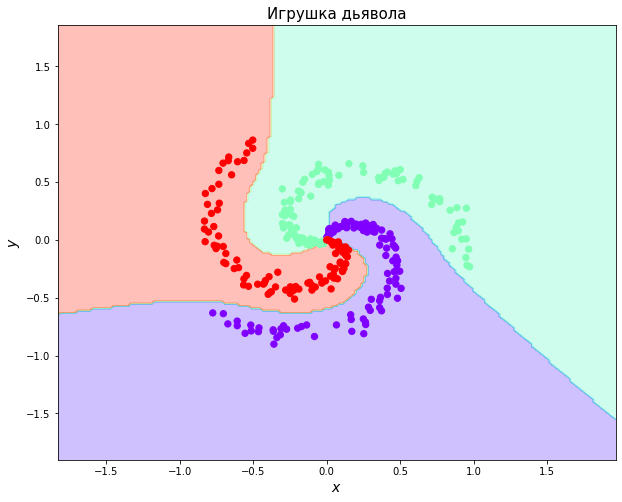

In [18]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

### Задача 2
https://pypi.org/project/python-mnist/

* __Задача:__ Распознать рукописную цифру (0-9)
* __Вход:__ картинка 28 x 28 пикселей (ч/б)

In [32]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets

In [33]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.5, ), (0.5, ))])

In [36]:
trainset = torchvision.datasets.MNIST('mnist', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST('mnist', train = False, download=True, transform=transform)

In [40]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 100, shuffle = True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 100, shuffle = False, num_workers=0)

In [41]:
nn.Conv2d(in_channels=1,
          out_channels=5,
          kernel_size=3,
          stride=1, 
          padding=1)

Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=1), 
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=1),  
                                      nn.MaxPool2d(2, 2),
                                      nn.ReLU(inplace=True), 
                                      nn.BatchNorm2d(10), 
                                      nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(20),
                                      nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, stride=1, padding=1),
                                      nn.MaxPool2d(2, 2),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(40))
        
        self.classifier = nn.Sequential(
            nn.Linear(7 * 7 * 40, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(200, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 10))
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 7 * 7 * 40)
        x = self.classifier(x)
        return x

In [46]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr = 3e-4,
                       weight_decay= 0.001)

In [48]:
batch_size = 100
features_train = trainset.data.shape[0]
n_iters = 6000
num_epochs = n_iters/(features_train/batch_size)                                                                             
num_epochs = int(num_epochs)
print("number of epochs: " + str(num_epochs))

number of epochs: 10


In [49]:
for i, data in enumerate(train_loader, 0):
    train, labels = data
    optimizer.zero_grad()
    outputs = model(train)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        train, labels = data
        optimizer.zero_grad()
        outputs = model(train)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            correct = 0
            total = 0
            for i, data in enumerate(test_loader, 0):
                test, labels = data
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 600 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*

6). *Подробнее про backprop -- статья на Medium: https://medium.com/autonomous-agents/backpropagation-how-neural-networks-learn-complex-behaviors-9572ac161670*

7). *Статья из интернет по Backprop: http://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf*